In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import sys
sys.path.append('src/')

eps=1e-8

from main import *
from utils import *

Transformation fo the mat files into csv files

In [2]:
file=hdf5storage.loadmat('../school_splits/school_b.mat')
mat_to_csv(file)

In [3]:
data=pd.read_csv('../data/school_results.csv')

y_df=data[['grade']]
X_df=data.drop(['grade'],axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_df,y_df,test_size=0.25)

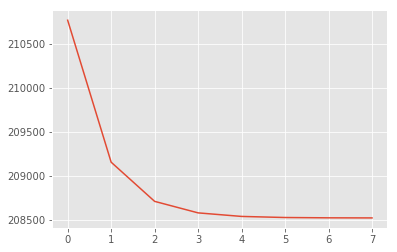

In [5]:
W,D,l,mineps,list_sqe=algo1_eps(X_train,y_train,gamma=1,tol=0.1,max_iter=20)
plt.plot(l)
plt.show()

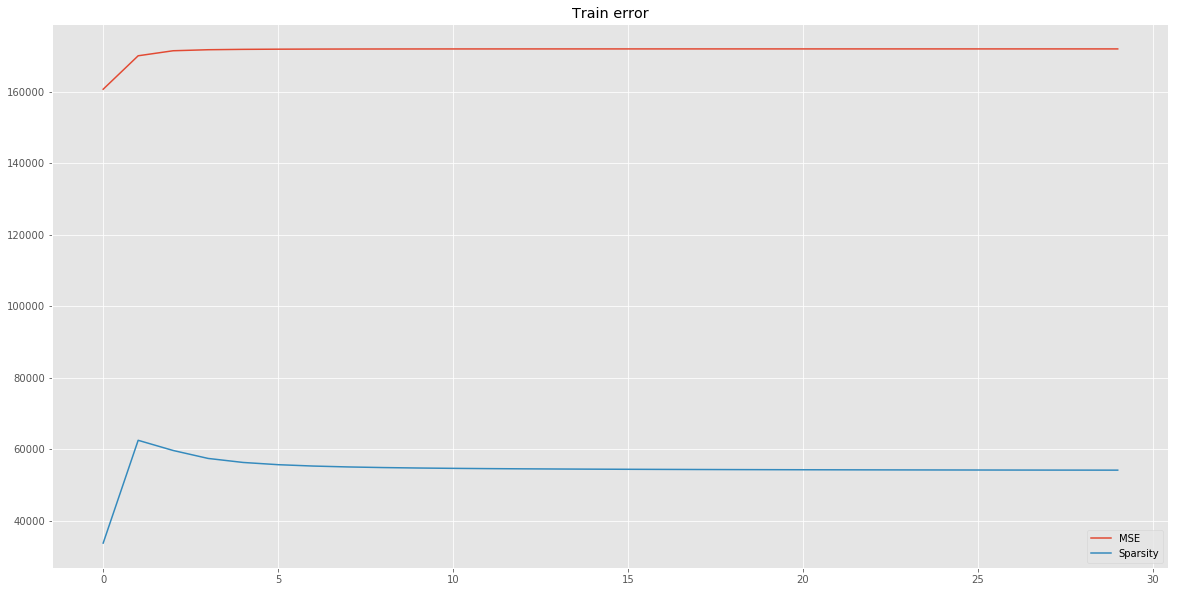

In [6]:
W,D,l,l_sqe,l_sparse=algo1(X_train,y_train,gamma=1,epsilon=0.01,tol=1e-5,max_iter=30)

plt.figure(figsize=(20,10))
plt.plot(l_sqe,label='MSE')
plt.plot(l_sparse,label='Sparsity')
plt.legend()
plt.title('Train error')
plt.show()

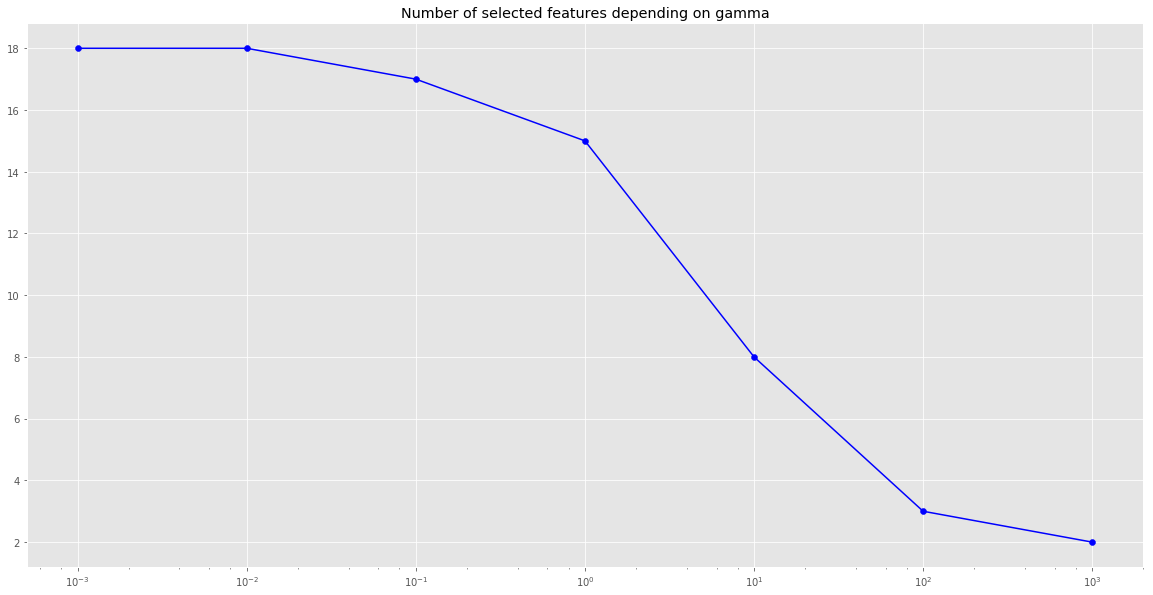

In [7]:
gammas=[]
n_feat=[]
for j in range(-3,4):
    gamma=10**(j)
    W,D,l,l_sqe,l_sparse=algo1(X_train,y_train,gamma,epsilon=0.01,tol=1e-5,max_iter=30)
    _,U=np.linalg.eig(D)
    A=np.dot(U.T,W)
    #print(gamma,[round(np.linalg.norm(a),1) for a in A])
    gammas.append(gamma)
    n_feat.append(len(np.where(np.array([round(np.linalg.norm(a),1) for a in A])>0)[0]))
plt.figure(figsize=(20,10))
plt.scatter(gammas,n_feat,c='b')
plt.plot(gammas,n_feat,c='b')
plt.xscale('log')
plt.title('Number of selected features depending on gamma')
plt.show()

In [7]:
X=X_train.drop('tasks',axis=1).values
K=np.dot(X,X.T)
idx=np.random.choice(np.arange(len(K)),size=1000,replace=False)
K_tmp=K[idx].T[idx].T

In [8]:
X_train,X_test,y_train,y_test=train_test_split(X_df,y_df,test_size=0.8)
B,K_til,mu_idx=algo2(X_train,y_train,gamma=1,
                     epsilon=0.1,tol=1e-5,max_iter=5)

675
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


In [14]:
y_pred=compute_y_pred_B(B,X_train,K_til)

In [16]:
np.linalg.norm(y_pred-y_train.values,ord=1)/len(y_pred)

20.646973555824516

In [5]:
X_train,X_test,y_train,y_test=train_test_split(X_df,y_df,test_size=0.9)

B,list_cost,mineps=algo2_eps(X_train,y_train,gamma=0.1,epsilon_init=1e-2,tol=1e-3,tol_eps=1e-7,max_iter=10,kernel='gaussian',sigma=None)

658
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
658
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
658
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
658
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
658
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
658
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10


In [6]:
list_cost

[20.531901041666668,
 20.531901041666668,
 20.531901041666668,
 20.531901041666668,
 20.531901041666668,
 20.531901041666668]

651
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
(138,)
(513,)
651
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
(138,)
(513,)
651
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
(138,)
(513,)
651
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
(138,)
(513,)
651
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
(138,)
(513,)
651
Iteration:  1
Iteration:  2
Iteration:  3
(138,)
(513,)
651
Iteration:  1
Iteration:  2
(138,)
(513,)


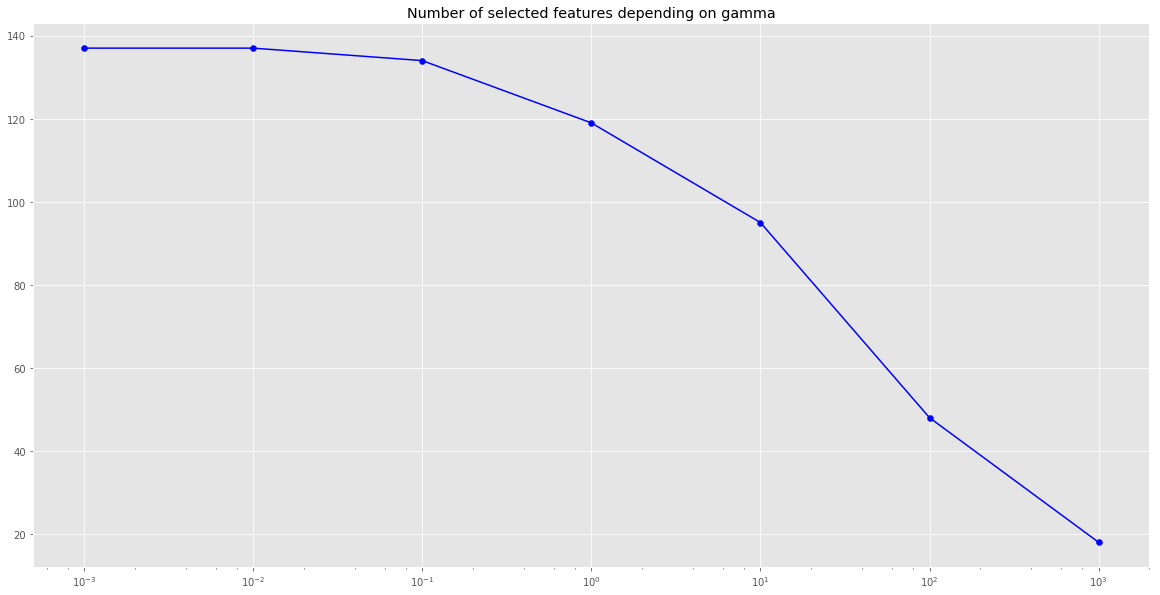

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X_df,y_df,test_size=0.9)
gammas=[]
n_feat=[]

for j in range(-3,4):
    gamma=10**(j)
    B,K_til,mu_idx=algo2(X_train,y_train,gamma,
                     epsilon=0.1,tol=1e-5,max_iter=5)
    A=compute_A_from_B(B,K_til,mu_idx)
    #print(gamma,[round(np.linalg.norm(a),1) for a in A])
    gammas.append(gamma)
    n_feat.append(len(np.where(np.array([round(np.linalg.norm(a),3) for a in A.T])>0)[0]))
    #B_list.append(B)
plt.figure(figsize=(20,10))
plt.scatter(gammas,n_feat,c='b')
plt.plot(gammas,n_feat,c='b')
plt.xscale('log')
plt.title('Number of selected features depending on gamma')
plt.show()

In [42]:
gammas

[0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [19]:
np.array([round(np.linalg.norm(a),1) for a in A.T])[:28]

array([  5.13000000e+02,   2.95200000e+02,   1.89900000e+02,
         7.38000000e+01,   2.47000000e+01,   9.20000000e+00,
         3.40000000e+00,   1.90000000e+00,   1.70000000e+00,
         1.10000000e+00,   1.10000000e+00,   6.00000000e-01,
         5.00000000e-01,   4.00000000e-01,   3.00000000e-01,
         3.00000000e-01,   2.00000000e-01,   1.00000000e-01,
         1.00000000e-01,   1.00000000e-01,   1.00000000e-01,
         1.00000000e-01,   1.00000000e-01,   1.00000000e-01,
         1.00000000e-01,   1.00000000e-01,   1.00000000e-01,
         1.00000000e-01])

In [33]:
B.shape

(656, 138)

In [39]:
np.linalg.norm(B,axis=1)

array([  3.02179999e+02,   6.39089736e+02,   8.01978929e+02,
         6.29982168e+02,   1.53045353e+02,   1.59663975e+02,
         2.17880867e+03,   1.64972310e+03,   5.72799670e+02,
         1.20105947e+03,   3.52188083e+02,   4.15205511e+02,
         1.31449984e+02,   1.99157194e+02,   3.11217115e+02,
         4.93511895e+02,   6.06331003e+02,   8.20432801e+01,
         8.80958280e+02,   3.22354441e+02,   3.46382499e+02,
         1.21563274e+03,   8.70777798e+02,   1.29737690e+03,
         1.18573837e+03,   4.81119970e+02,   1.29172105e+01,
         8.37916977e+02,   5.05854481e+02,   6.85554368e+02,
         5.56064866e+02,   4.90927560e+01,   1.17388403e+03,
         4.28416973e+02,   6.04002463e+02,   2.18132717e+02,
         1.07687924e+02,   4.75104987e+02,   2.55328555e+03,
         1.15585766e+01,   2.60190649e+02,   1.87802708e+03,
         2.97895800e+02,   5.75231674e+02,   2.71741402e+02,
         1.53809304e+03,   1.44878737e+02,   1.02607142e+03,
         1.71892857e+03,

In [17]:
from sklearn.cross_decomposition import PLSRegression

clf=PLSRegression()

clf.fit(X_train,y_train)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

In [9]:
y_pred_LDA=clf.predict(X_train)

In [12]:
np.linalg.norm(y_pred_LDA-y_train.values)/len(y_pred_LDA)

21.460059748954823

In [13]:
X_new=clf.fit_transform(X_train,y_train)

In [15]:
x_plot=[x[0] for x in X_new]
y_plot=[y[0] for y in X_new]

In [24]:
importance=clf.coef_/np.linalg.norm(clf.coef_)

In [30]:
explained_var(compute_y_pred_B(B,X_train,K_til),y_train.values)

-2.6917368697107946

In [ ]:
M=np.array([])

In [27]:
np.sqrt(np.var(y_train.values))

12.624597373056581